In [1]:
import os
import sys

# Add the parent directory of the current script and 'src' folder to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.model_unet_no_attention import *

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load your saved data
test_data = torch.load("../data/prepared_datasets/train_flowers.pt")
test_labels = torch.load("../data/prepared_datasets/train_flowers_labels.pt")
val_data = torch.load("../data/prepared_datasets/val_flowers.pt")
val_labels = torch.load("../data/prepared_datasets/val_flowers_labels.pt")
train_data = torch.load("../data/prepared_datasets/test_flowers.pt")
train_labels = torch.load("../data/prepared_datasets/test_flowers_labels.pt")

In [3]:
train_data.shape

torch.Size([6149, 3, 64, 64])

In [4]:
batch_size = 32

In [5]:
def prepare_data_loaders(train_data, train_labels, val_data, val_labels, test_data, test_labels, batch_size=batch_size):
    train_dataset = TensorDataset(train_data, train_labels)
    val_dataset = TensorDataset(val_data, val_labels)
    test_dataset = TensorDataset(test_data, test_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

In [6]:
# Normalize data to [0, 1] if not already done
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
val_data = (val_data - val_data.min()) / (val_data.max() - val_data.min())
test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())

train_data = train_data * 2 - 1
val_data = val_data * 2 - 1
test_data = test_data * 2 - 1
# Create data loaders
train_loader, val_loader, test_loader = prepare_data_loaders(train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [7]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

In [8]:
from torch.optim import Adam
from torch.optim import AdamW

image_size = 64
channels = 3

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

#optimizer = Adam(model.parameters(), lr=5e-3)
#optimizer = AdamW(model.parameters(), lr=5e-3)
optimizer = Adam(model.parameters(), lr=1e-3)

cuda


In [9]:
timesteps = 200
betas = DiffusionSchedule.linear_beta_schedule(timesteps).clone()
diffusion_params = DiffusionSchedule.compute_diffusion_parameters(betas)

In [15]:
from torchvision.utils import save_image

epochs = 20
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
        data = data.to(device)
        optimizer.zero_grad()

        #batch_size = batch["pixel_values"].shape[0]
        #batch = batch["pixel_values"].to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        if data.shape[0] == batch_size:
            
            loss = p_losses(model, data, t, loss_type="huber", diffusion_params=diffusion_params)
            
            if batch_idx % 100 == 0:
                print("Loss:", loss.item())
            
            loss.backward()
            optimizer.step()
            
            # save generated images
            if batch_idx != 0 and batch_idx % save_and_sample_every == 0:
                milestone = batch_idx // save_and_sample_every
                batches = num_to_groups(4, batch_size)
                all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
                all_images = torch.cat(all_images_list, dim=0)
                all_images = (all_images + 1) * 0.5
                save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

Epoch 1/20:   1%|          | 1/193 [00:00<01:23,  2.30it/s]

Loss: 0.038649290800094604


Epoch 1/20:  52%|█████▏    | 101/193 [00:12<00:10,  8.39it/s]

Loss: 0.02893665060400963


Epoch 2/20:   1%|          | 2/193 [00:00<00:22,  8.62it/s]

Loss: 0.03450890630483627


Epoch 2/20:  52%|█████▏    | 101/193 [00:12<00:11,  8.13it/s]

Loss: 0.0313970223069191


Epoch 3/20:   1%|          | 2/193 [00:00<00:21,  8.89it/s]

Loss: 0.029095042496919632


Epoch 3/20:  53%|█████▎    | 102/193 [00:12<00:10,  8.69it/s]

Loss: 0.03710785508155823


Epoch 4/20:   1%|          | 1/193 [00:00<00:22,  8.36it/s]

Loss: 0.03856898844242096


Epoch 4/20:  53%|█████▎    | 102/193 [00:11<00:10,  8.73it/s]

Loss: 0.04314988851547241


Epoch 5/20:   1%|          | 1/193 [00:00<00:22,  8.66it/s]

Loss: 0.04654081165790558


Epoch 5/20:  53%|█████▎    | 102/193 [00:11<00:10,  8.69it/s]

Loss: 0.04916892573237419


Epoch 6/20:   1%|          | 1/193 [00:00<00:22,  8.57it/s]

Loss: 0.031162410974502563


Epoch 6/20:  52%|█████▏    | 101/193 [00:11<00:10,  8.53it/s]

Loss: 0.03881623595952988


Epoch 7/20:   1%|          | 1/193 [00:00<00:22,  8.41it/s]

Loss: 0.044548921287059784


Epoch 7/20:  53%|█████▎    | 102/193 [00:11<00:10,  8.37it/s]

Loss: 0.03348638489842415


Epoch 8/20:   1%|          | 2/193 [00:00<00:22,  8.51it/s]

Loss: 0.05482393130660057


Epoch 8/20:  53%|█████▎    | 102/193 [00:12<00:10,  8.53it/s]

Loss: 0.023369375616312027


Epoch 9/20:   1%|          | 2/193 [00:00<00:22,  8.52it/s]

Loss: 0.04259299859404564


Epoch 9/20:  53%|█████▎    | 102/193 [00:12<00:10,  8.48it/s]

Loss: 0.0318404957652092


Epoch 10/20:   1%|          | 2/193 [00:00<00:22,  8.63it/s]

Loss: 0.037050969898700714


Epoch 10/20:  53%|█████▎    | 102/193 [00:11<00:10,  8.82it/s]

Loss: 0.05622568354010582


Epoch 11/20:   1%|          | 2/193 [00:00<00:21,  8.91it/s]

Loss: 0.04735435172915459


Epoch 11/20:  53%|█████▎    | 102/193 [00:11<00:10,  8.56it/s]

Loss: 0.05280644819140434


Epoch 12/20:   1%|          | 2/193 [00:00<00:21,  8.73it/s]

Loss: 0.02964898571372032


Epoch 12/20:  53%|█████▎    | 102/193 [00:12<00:10,  8.45it/s]

Loss: 0.057594459503889084


Epoch 13/20:   1%|          | 2/193 [00:00<00:22,  8.50it/s]

Loss: 0.03216937184333801


Epoch 13/20:  53%|█████▎    | 102/193 [00:11<00:10,  8.74it/s]

Loss: 0.03415407985448837


Epoch 14/20:   1%|          | 1/193 [00:00<00:23,  8.06it/s]

Loss: 0.02951645478606224


Epoch 14/20:  52%|█████▏    | 101/193 [00:11<00:11,  8.19it/s]

Loss: 0.024464113637804985


Epoch 15/20:   1%|          | 1/193 [00:00<00:22,  8.51it/s]

Loss: 0.035090647637844086


Epoch 15/20:  53%|█████▎    | 102/193 [00:11<00:10,  8.66it/s]

Loss: 0.029759038239717484


Epoch 16/20:   1%|          | 2/193 [00:00<00:22,  8.67it/s]

Loss: 0.04005148634314537


Epoch 16/20:  53%|█████▎    | 102/193 [00:11<00:10,  8.60it/s]

Loss: 0.042683474719524384


Epoch 17/20:   1%|          | 2/193 [00:00<00:22,  8.62it/s]

Loss: 0.031434670090675354


Epoch 17/20:  53%|█████▎    | 102/193 [00:12<00:10,  8.29it/s]

Loss: 0.04762279614806175


Epoch 18/20:   1%|          | 2/193 [00:00<00:21,  8.97it/s]

Loss: 0.024109823629260063


Epoch 18/20:  53%|█████▎    | 102/193 [00:11<00:10,  8.51it/s]

Loss: 0.04075978696346283


Epoch 19/20:   1%|          | 2/193 [00:00<00:21,  8.84it/s]

Loss: 0.03337293490767479


Epoch 19/20:  52%|█████▏    | 101/193 [00:11<00:10,  8.58it/s]

Loss: 0.030768176540732384


Epoch 20/20:   1%|          | 2/193 [00:00<00:22,  8.51it/s]

Loss: 0.033808160573244095


Epoch 20/20:  53%|█████▎    | 102/193 [00:11<00:10,  8.53it/s]

Loss: 0.02410062961280346


Epoch 20/20: 100%|██████████| 193/193 [00:22<00:00,  8.67it/s]


In [18]:
torch.save({
    'epoch': epochs,
    'batch_size':batch_size,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, 'model_4.pth')

In [19]:
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
checkpoint = torch.load('model_4.pth')
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict)

model = model.to(device)

In [16]:
print(image_size,channels)
samples = sample(model, image_size=image_size, batch_size=batch_size, channels=channels, diffusion_params=diffusion_params)

64 3


sampling loop time step: 100%|██████████| 200/200 [00:07<00:00, 26.86it/s]


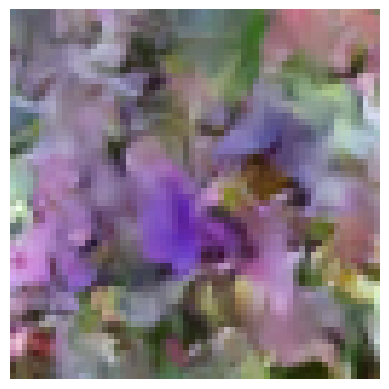

In [17]:
import numpy as np
img = samples[-1][3]
img = img.cpu().numpy()
img = np.transpose(img, (1, 2, 0))
img = (img - img.min()) / (img.max() - img.min())
plt.imshow(img)
plt.axis('off')  # Hide axis
#plt.imsave("saved_image_no_attention.png", img)
plt.show()

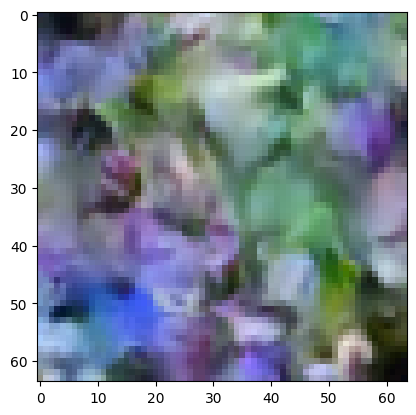

In [13]:
random_index = 3
plt.imshow(img.reshape(image_size, image_size, channels))

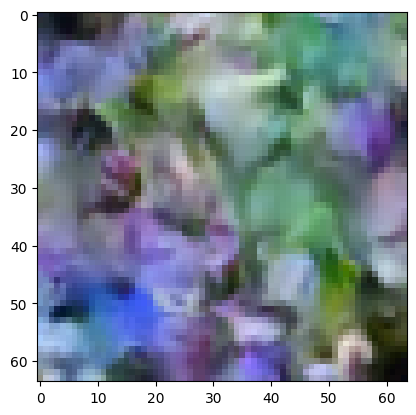

In [14]:
import matplotlib.animation as animation

random_index = 3

fig = plt.figure()
ims = []
#print(samples[2][0].shape)
for i in range(timesteps):
    img = samples[i][random_index]
    img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0)) 
    #img = samples[i][random_index].reshape(image_size, image_size, channels)
    img = (img - img.min()) / (img.max() - img.min())
    im = plt.imshow(img, animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
#animate.save('diffusion.gif')
plt.show()

In [18]:
timesteps

200